In [46]:
import sys
sys.path.append('../code/')

from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from joblib import Parallel, delayed
from itertools import product

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf
from arch import arch_model
from pylab import rcParams
from datetime import timedelta
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

from preprocessing_utils import preprocess_df
from plot_utils import plot_store_charts, plot_folds
from test_utils import run_stat_test
from sm_utils import compute_pacf_acf, StatmodelsWrapper, run_k_fold_tain_val_statmodels
from metrics import mean_absolute_error, rmse, rss, r2_score, durbin_watson, mean_squared_error, mean_absolute_percentage_error

%matplotlib inline
rcParams['figure.figsize'] = 20, 10

# Load Data

In [2]:
ts = pd.read_csv('../data/US1.NVDA_200101_210215.csv', delimiter=';')
ts = preprocess_df(ts)
ts

,ticker,per,date,time,open,high,low,close,vol,Nclose
0,US1.NVDA,D,2020-01-02,0,238.85,239.88,236.73,239.79,303428,0.392886
1,US1.NVDA,D,2020-01-03,0,234.65,237.81,234.17,236.37,268936,0.387282
2,US1.NVDA,D,2020-01-06,0,232.21,237.25,231.52,237.07,432624,0.388429
3,US1.NVDA,D,2020-01-07,0,238.03,241.76,236.39,239.83,576787,0.392951
4,US1.NVDA,D,2020-01-08,0,239.65,242.04,238.15,240.42,540373,0.393918
...,...,...,...,...,...,...,...,...,...,...
275,US1.NVDA,D,2021-02-08,0,549.96,578.93,549.96,577.70,316219,0.946537
276,US1.NVDA,D,2021-02-09,0,574.02,583.00,568.90,570.35,142242,0.934494
277,US1.NVDA,D,2021-02-10,0,579.02,596.20,574.45,590.72,320581,0.967870
278,US1.NVDA,D,2021-02-11,0,599.50,610.89,597.61,610.33,268265,1.000000


# Plot Data

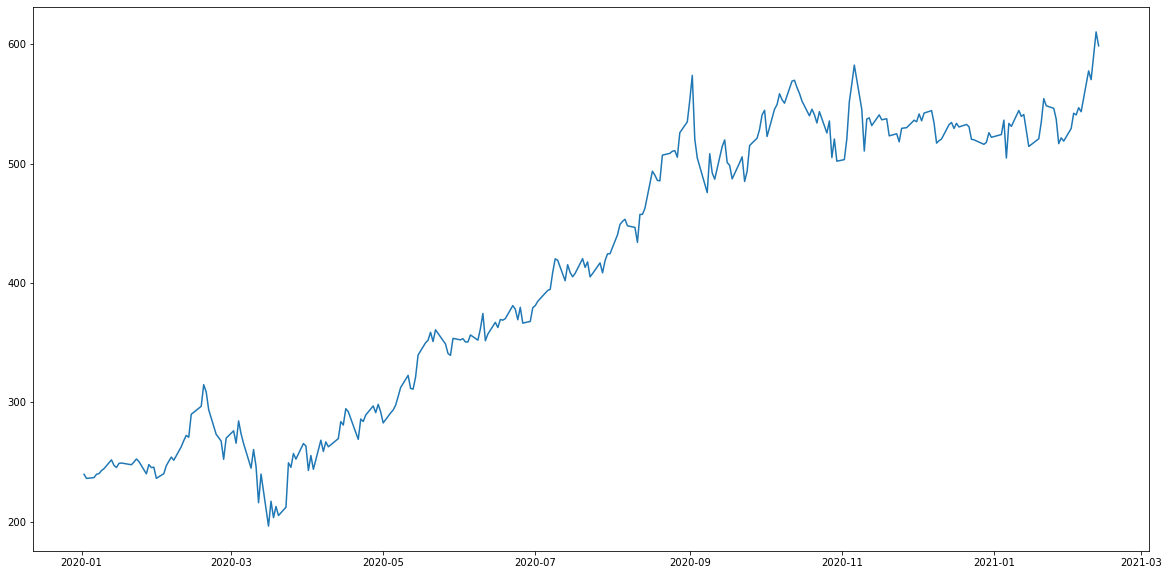

In [3]:
plt.plot(ts['date'], ts['close'])

(array([10., 54., 25., 21., 18., 19., 12., 50., 62.,  9.]),
 array([196.45 , 237.838, 279.226, 320.614, 362.002, 403.39 , 444.778,
        486.166, 527.554, 568.942, 610.33 ]),
 <BarContainer object of 10 artists>)

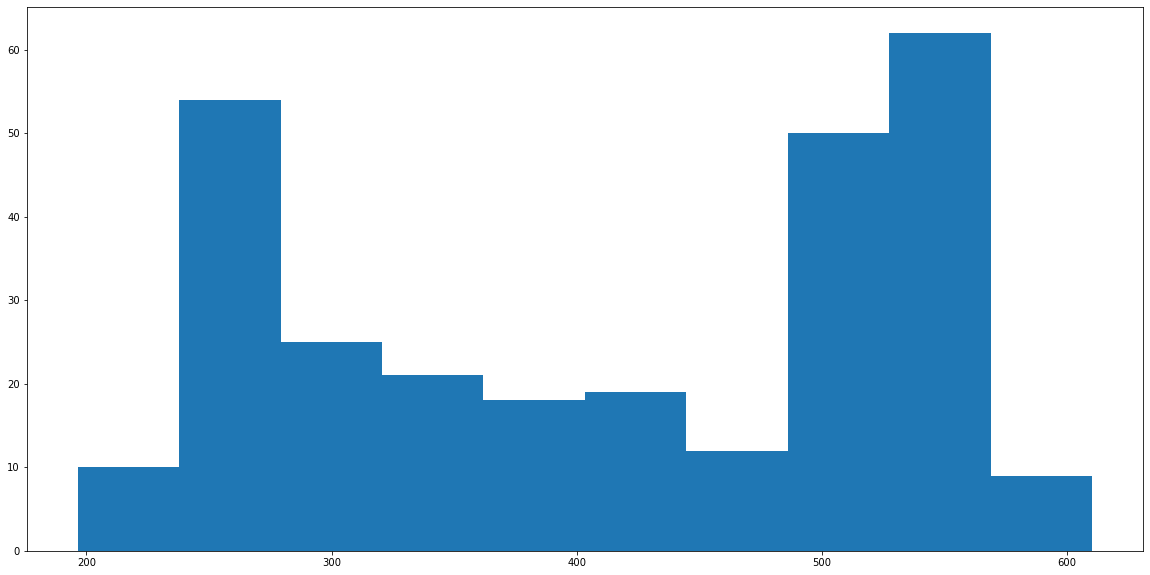

In [4]:
plt.hist(ts['close'])

In [5]:
overall_period_in_days = (ts['date'].iloc[-1] - ts['date'].iloc[0]).days

fake_ts = pd.DataFrame({
    'date': [ts['date'].min() + timedelta(days=i) for i in range(overall_period_in_days + 1)]
})
fake_ts = fake_ts.merge(ts[['date', 'close']], on='date', how='left')
fake_ts['missed'] = 0
fake_ts.loc[fake_ts['close'].isna(), 'missed'] = 1
fake_ts.loc[fake_ts['close'].isna(), 'close'] = -1

fake_ts

,date,close,missed
0,2020-01-02,239.79,0
1,2020-01-03,236.37,0
2,2020-01-04,-1.00,1
3,2020-01-05,-1.00,1
4,2020-01-06,237.07,0
...,...,...,...
403,2021-02-08,577.70,0
404,2021-02-09,570.35,0
405,2021-02-10,590.72,0
406,2021-02-11,610.33,0


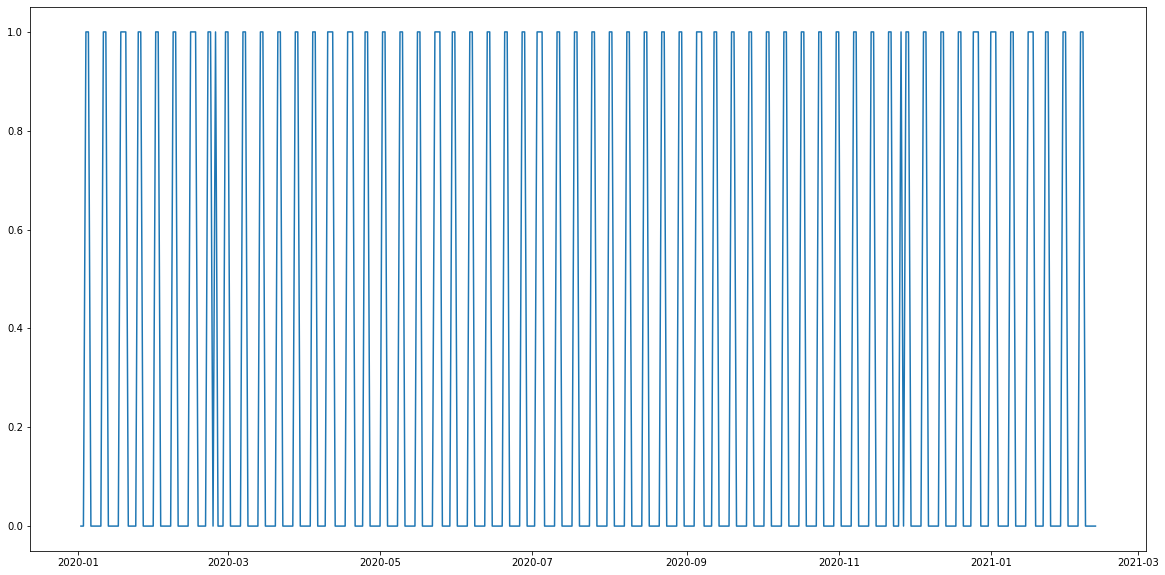

In [6]:
plt.plot(fake_ts['date'], fake_ts['missed'])

(array([280.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

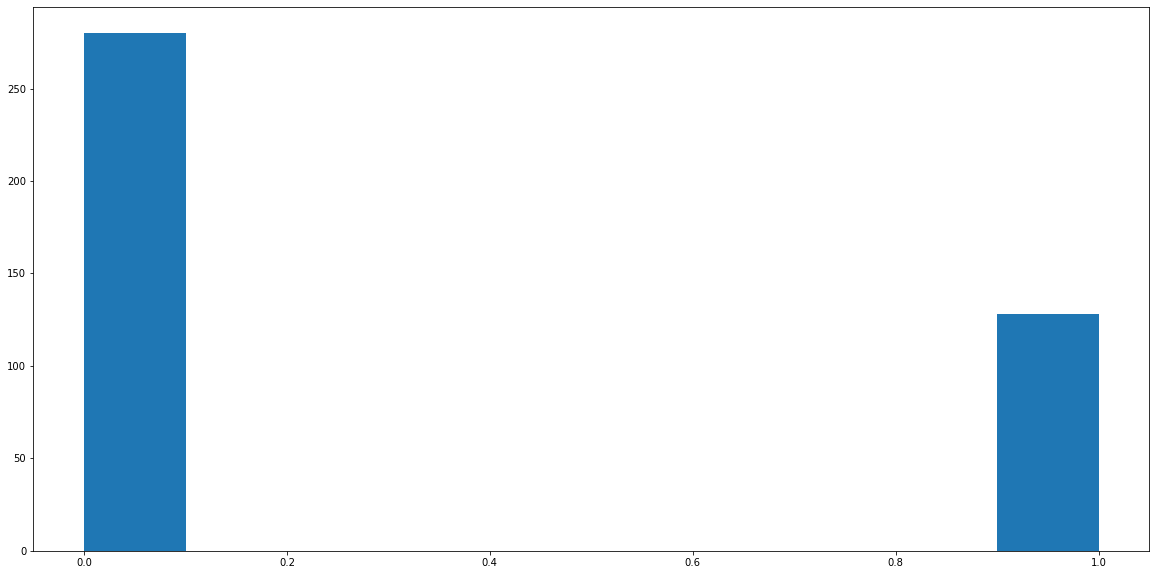

In [7]:
plt.hist(fake_ts['missed'])

# Check stationarity and decompose

In [8]:
test_results = {}
test_results.update(run_stat_test(ts['close'], adfuller))
test_results.update(run_stat_test(ts['close'], kpss, 3))

pd.Series(test_results)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


adfuller_statistics           -0.530404
adfuller_p_value               0.885946
adfuller_critical_value_1%    -3.454355
adfuller_critical_value_5%    -2.872108
adfuller_critical_value_10%   -2.572401
kpss_statistics                1.673479
kpss_p_value                   0.010000
kpss_critical_value_10%        0.347000
kpss_critical_value_5%         0.463000
kpss_critical_value_2.5%       0.574000
kpss_critical_value_1%         0.739000
dtype: float64

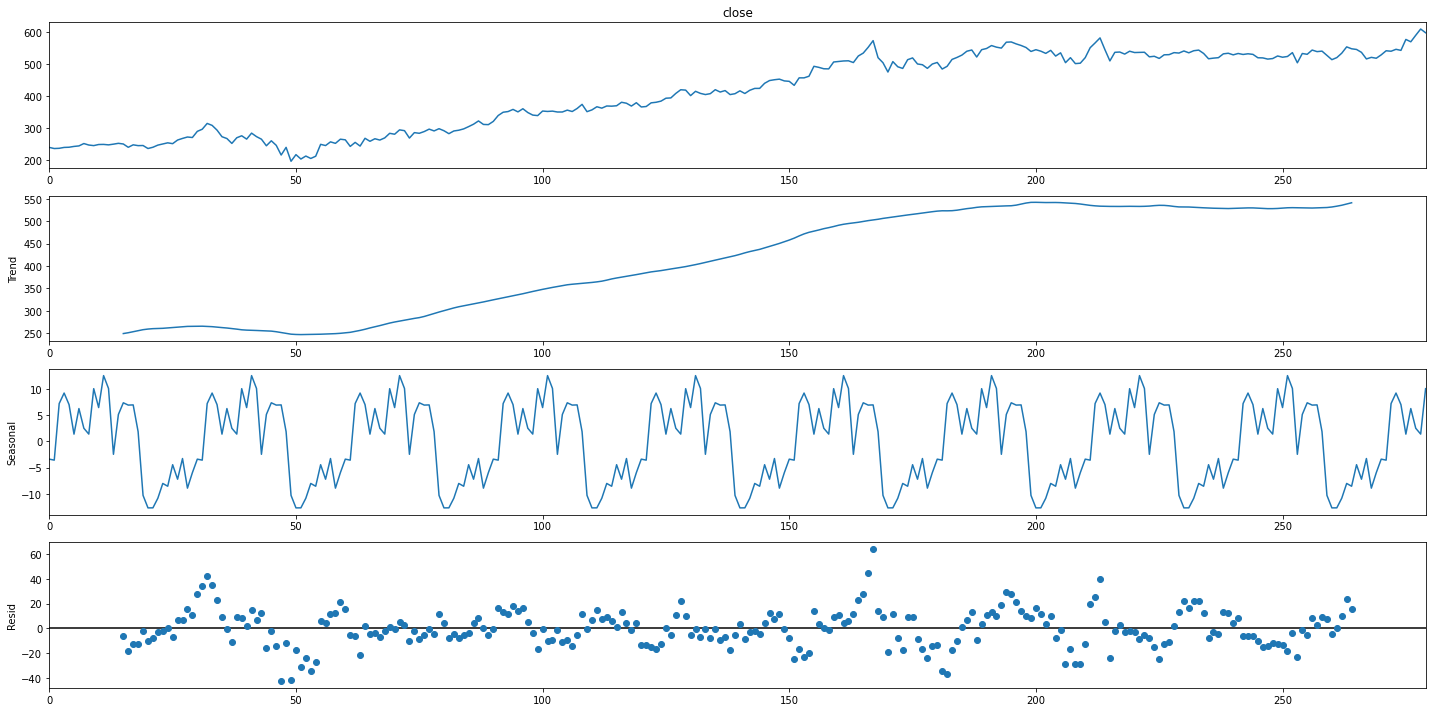

In [9]:
sesonal_dec = seasonal_decompose(ts['close'], period=30)
sesonal_dec.plot()
plt.show()

In [10]:
close_log_diff_1 = np.log1p(ts['close']).diff(periods=1)

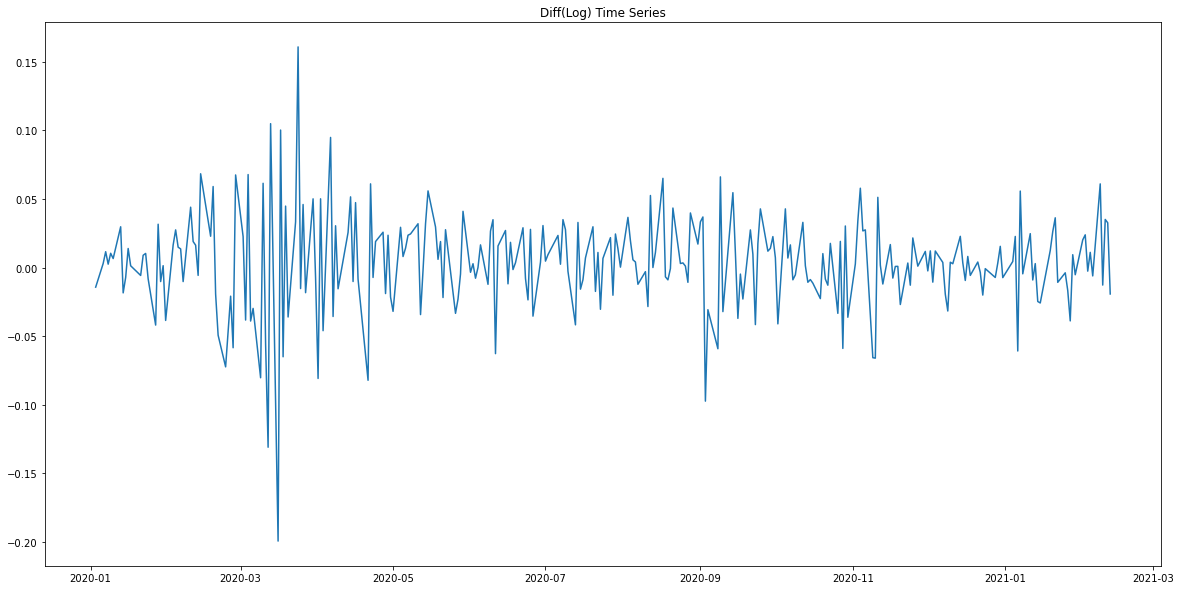

In [11]:
plt.title('Diff(Log) Time Series')
plt.plot(ts['date'], close_log_diff_1)
plt.show()

In [12]:
close_log_diff_1 = close_log_diff_1.dropna()

In [13]:
test_results = {}
test_results.update(run_stat_test(close_log_diff_1, adfuller))
test_results.update(run_stat_test(close_log_diff_1, kpss, 3))

pd.Series(test_results)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller_statistics           -6.673431e+00
adfuller_p_value               4.527275e-09
adfuller_critical_value_1%    -3.454622e+00
adfuller_critical_value_5%    -2.872225e+00
adfuller_critical_value_10%   -2.572464e+00
kpss_statistics                8.068829e-02
kpss_p_value                   1.000000e-01
kpss_critical_value_10%        3.470000e-01
kpss_critical_value_5%         4.630000e-01
kpss_critical_value_2.5%       5.740000e-01
kpss_critical_value_1%         7.390000e-01
dtype: float64

(array([  1.,   1.,   1.,  13.,  39., 133.,  74.,  13.,   3.,   1.]),
 array([-0.19931155, -0.16330706, -0.12730258, -0.09129809, -0.05529361,
        -0.01928912,  0.01671536,  0.05271984,  0.08872433,  0.12472881,
         0.1607333 ]),
 <BarContainer object of 10 artists>)

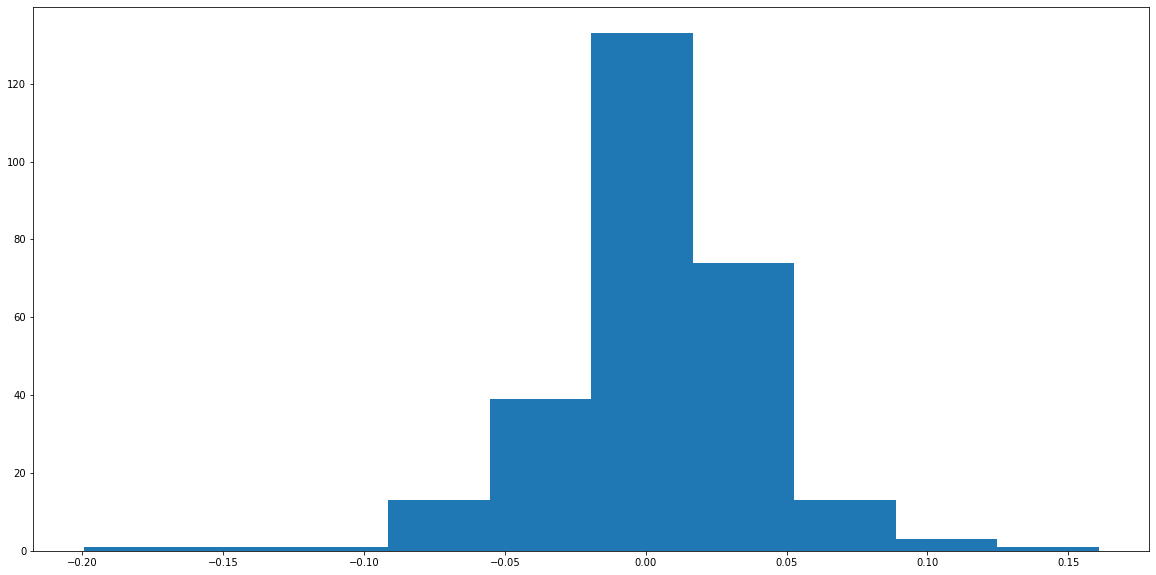

In [14]:
plt.hist(close_log_diff_1)

In [15]:
shapiro(close_log_diff_1)

ShapiroResult(statistic=0.94145268201828, pvalue=4.390017682709413e-09)

# Modelling

## CV split

In [16]:
fold_ids = list(TimeSeriesSplit(test_size=7).split(close_log_diff_1))

# Trim start in order to have same size folds
train_fold_len = min([len(el[0]) for el in fold_ids])
for i in range(len(fold_ids)):
    fold_ids[i] = (fold_ids[i][0][-train_fold_len:], fold_ids[i][1])

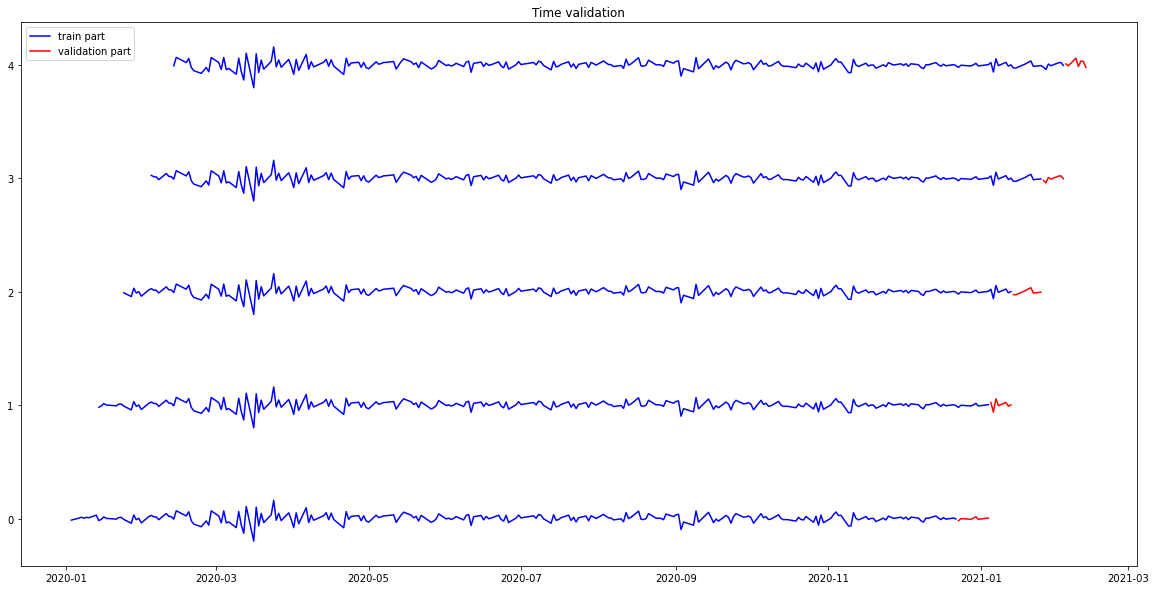

In [17]:
plt.title(f"Time validation")
for fold_n, (train_ids, val_ids) in enumerate(fold_ids):
    train_sub_df = close_log_diff_1.iloc[train_ids]
    val_sub_df = close_log_diff_1.iloc[val_ids]

    if fold_n == len(fold_ids) - 1:
        plt.plot(
            ts.loc[train_sub_df.index, "date"],
            train_sub_df + float(fold_n),
            "b",
            label="train part",
        )
        plt.plot(
            ts.loc[val_sub_df.index, "date"],
            val_sub_df + float(fold_n),
            "r",
            label="validation part",
        )
    else:
        plt.plot(
            ts.loc[train_sub_df.index, "date"],
            train_sub_df + float(fold_n),
            "b",
        )
        plt.plot(
            ts.loc[val_sub_df.index, "date"],
            val_sub_df + float(fold_n),
            "r"
        )

plt.legend()
plt.show()

## AR

In [18]:
def build_pacf(time_s, confidence, n_lags):
    pacf_result = pacf(time_s, nlags=n_lags)
    
    plt.title('PACF')
    plt.plot([confidence]*(n_lags + 1), "g", label="upper bound")
    plt.scatter(list(range(n_lags + 1)), pacf_result)
    plt.plot([-confidence]*(n_lags + 1), "r", label="lower bound")
    plt.legend()
    plt.show()
    
    print("Impoetant lags: ", np.where(np.abs(pacf_result) > confidence)[0] )
    
def compute_metrics(y_pred, y_true, prefix):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    return {
        f"{prefix}_RMSE": np.sqrt(sum((y_pred-y_true)**2)/len(y_true)),
        f"{prefix}_RSS": sum((y_pred-y_true)**2),
        f"{prefix}_R2": r2_score(y_true, y_pred),
        f"{prefix}_MSE": mean_squared_error(y_true, y_pred),
        f"{prefix}_MAE": mean_absolute_error(y_true, y_pred),
        f"{prefix}_MAPE": mean_absolute_percentage_error(y_true, y_pred),
        f"{prefix}_durbin_watson": durbin_watson(np.abs(y_true - y_pred)),
    }

def avarage_by_folds(metric_dicts):
    all_keys = metric_dicts[0].keys()
    return {
        k:np.mean([metric_dict[k] for metric_dict in metric_dicts]) for k in all_keys
    }

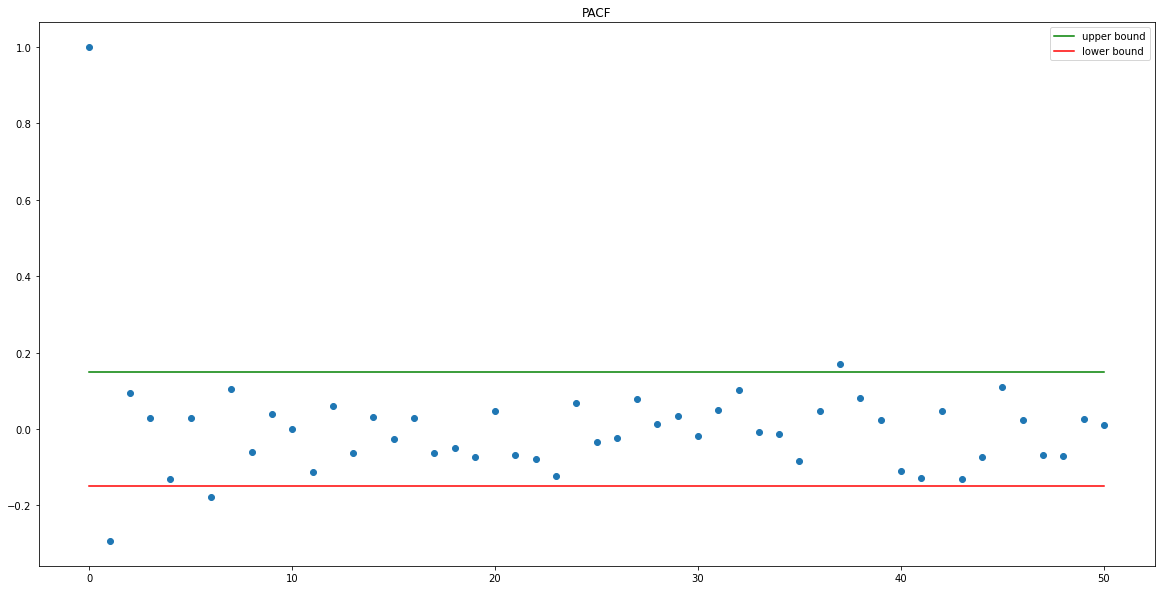

Impoetant lags:  [ 0  1  6 37]


In [19]:
build_pacf(close_log_diff_1, 0.15, 50)

In [ ]:
AR_result = {
    "AR": []
}

for autoreg in tqdm(list(range(1,13)) + [37]) :
    accum_metrics = []
    for fold_n, (train_ids, val_ids) in enumerate(fold_ids):
        temp_model = StatmodelsWrapper(
            stat_model=ARIMA,
            stat_model_config={
                "order": (autoreg,0,0)
            }
        )
        
        temp_model.fit(close_log_diff_1.iloc[train_ids])
        
        temp_result = compute_metrics(
            temp_model.model.predict(),
            close_log_diff_1.iloc[train_ids],
            'train'
        )
        
        temp_result["train_aic"] = temp_model.model.aic
        temp_result["train_bic"] = temp_model.model.bic
        
        temp_pred = temp_model.dynamic_predict(len(val_ids))
        
        temp_result.update(compute_metrics(
            temp_pred,
            close_log_diff_1.iloc[val_ids],
            'val'
        ))
        accum_metrics.append(temp_result)
        
    accum_metrics = avarage_by_folds(accum_metrics)
    
    AR_result["AR"].append(autoreg)
    for k in accum_metrics.keys():
        if k not in AR_result:
            AR_result[k] = []
            
        AR_result[k].append(accum_metrics[k])
    

In [ ]:
AR_result = pd.DataFrame(AR_result)

AR_result.sort_values('val_MAPE')

In [ ]:
AR_result.sort_values('train_MAPE').iloc[:,:10]

In [ ]:
AR_result.sort_values('val_MAPE').iloc[:,[0, 10, 11, 12, 13, 14, 15, 16]]

In [20]:
temp_model = StatmodelsWrapper(
    stat_model=ARIMA,
    stat_model_config={
        "order": (5,0,0)
    }
)

temp_model.fit(close_log_diff_1.iloc[fold_ids[0][0]])
train_temp_pred = temp_model.model.predict()
val_temp_pred = temp_model.dynamic_predict(7)

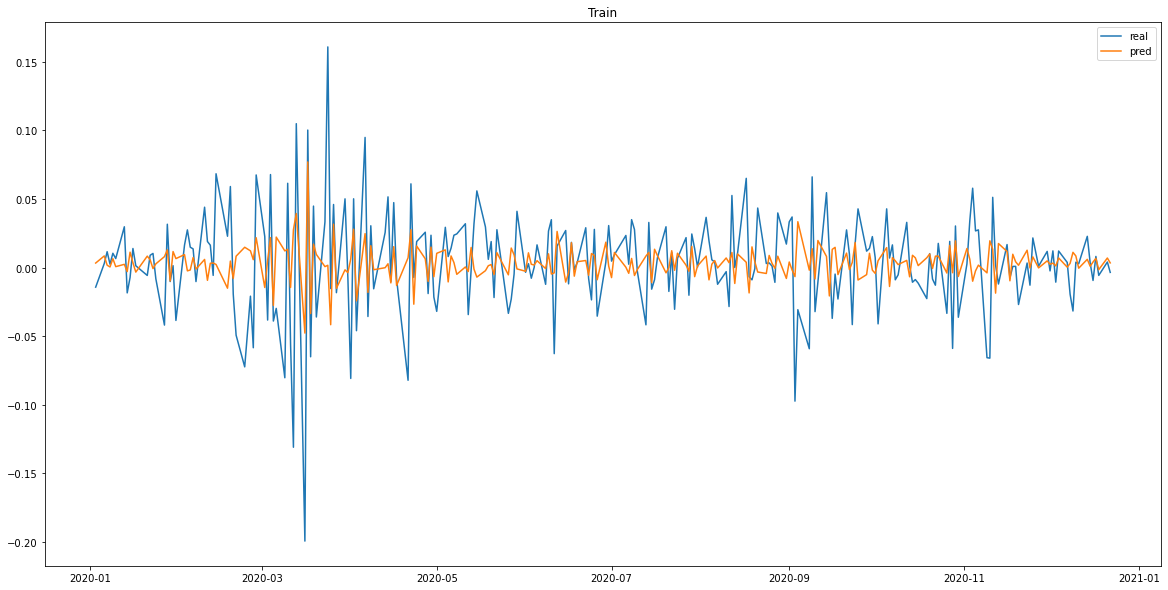

In [21]:
plt.title("Train")
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][0]].index], close_log_diff_1.iloc[fold_ids[0][0]], label='real')
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][0]].index], train_temp_pred, label='pred')
plt.legend()
plt.show()

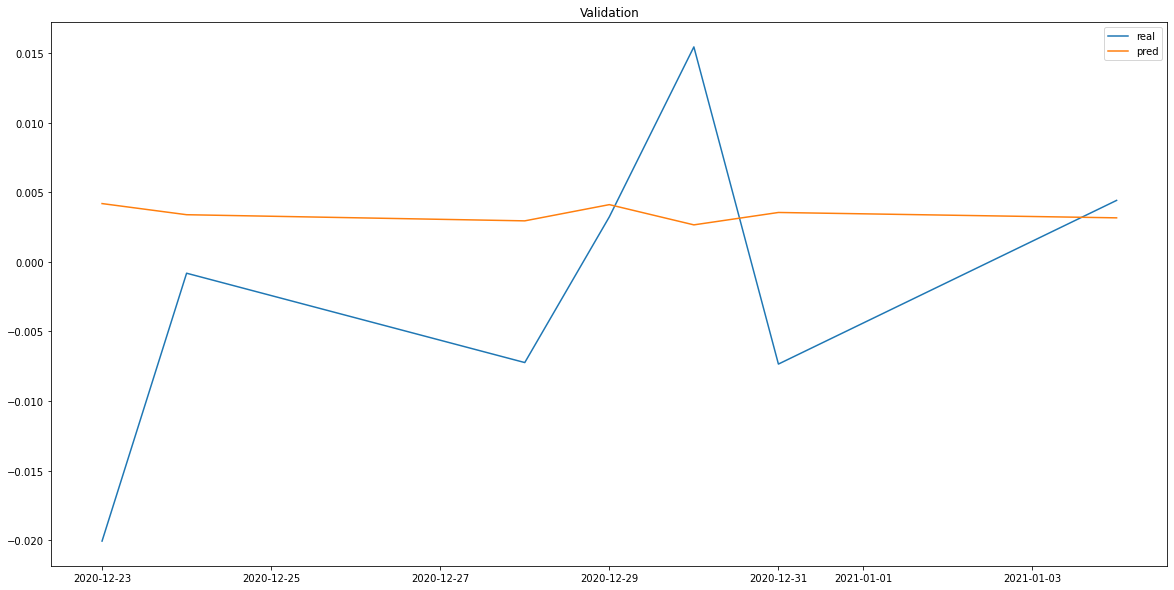

In [22]:
plt.title("Validation")
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][1]].index], close_log_diff_1.iloc[fold_ids[0][1]], label='real')
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][1]].index], val_temp_pred, label='pred')
plt.legend()
plt.show()

## ARMA

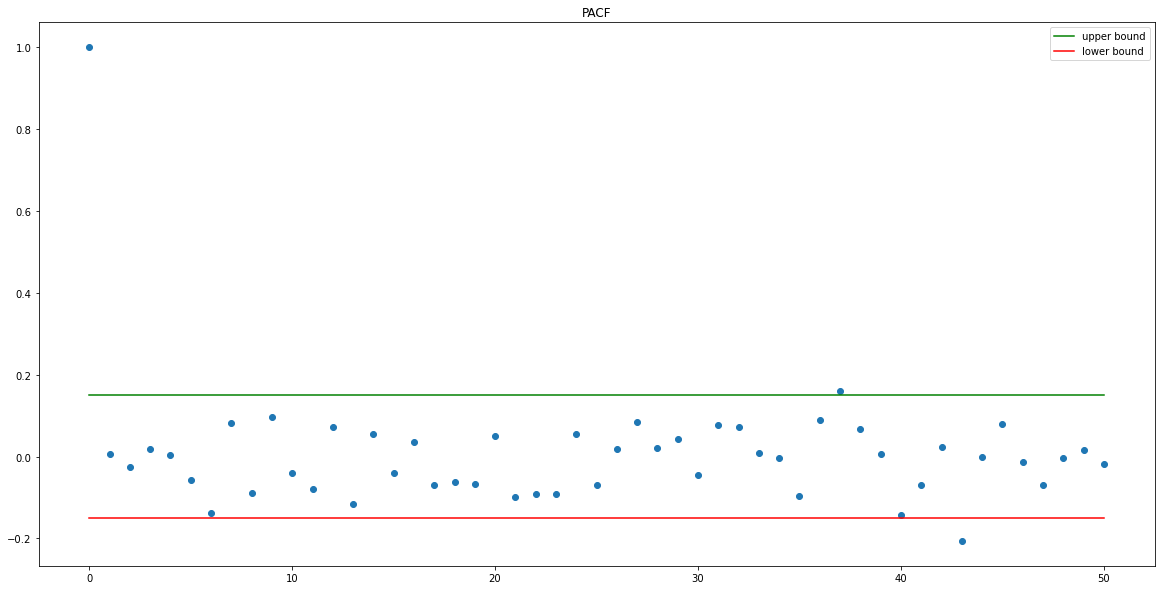

Impoetant lags:  [ 0 37 43]


In [23]:
build_pacf(temp_model.model.resid, 0.15, 50)

In [ ]:
ARMA_result = {
    "AR": [],
    "MA": []
}

for autoreg in tqdm([4,5,8]):
    for moveaver in list(range(1,4)):
        accum_metrics = []
        for fold_n, (train_ids, val_ids) in enumerate(fold_ids):
            temp_model = StatmodelsWrapper(
                stat_model=ARIMA,
                stat_model_config={
                    "order": (autoreg,0,moveaver)
                }
            )

            temp_model.fit(close_log_diff_1.iloc[train_ids])

            temp_result = compute_metrics(
                temp_model.model.predict(),
                close_log_diff_1.iloc[train_ids],
                'train'
            )

            temp_result["train_aic"] = temp_model.model.aic
            temp_result["train_bic"] = temp_model.model.bic

            temp_pred = temp_model.dynamic_predict(len(val_ids))

            temp_result.update(compute_metrics(
                temp_pred,
                close_log_diff_1.iloc[val_ids],
                'val'
            ))
            accum_metrics.append(temp_result)

        accum_metrics = avarage_by_folds(accum_metrics)

        ARMA_result["AR"].append(autoreg)
        ARMA_result["MA"].append(moveaver)
        for k in accum_metrics.keys():
            if k not in ARMA_result:
                ARMA_result[k] = []

            ARMA_result[k].append(accum_metrics[k])

In [ ]:
ARMA_result = pd.DataFrame(ARMA_result)

ARMA_result.sort_values('val_MAPE')

In [ ]:
ARMA_result.sort_values('train_MAPE').iloc[:,:11]

In [ ]:
ARMA_result.sort_values('val_MAPE').iloc[:,[0, 1, 10, 11, 12, 13, 14, 15, 16, 17]]

In [24]:
temp_model = StatmodelsWrapper(
    stat_model=ARIMA,
    stat_model_config={
        "order": (5,0,3)
    }
)

temp_model.fit(close_log_diff_1.iloc[fold_ids[0][0]])
train_temp_pred = temp_model.model.predict()
val_temp_pred = temp_model.dynamic_predict(7)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-p

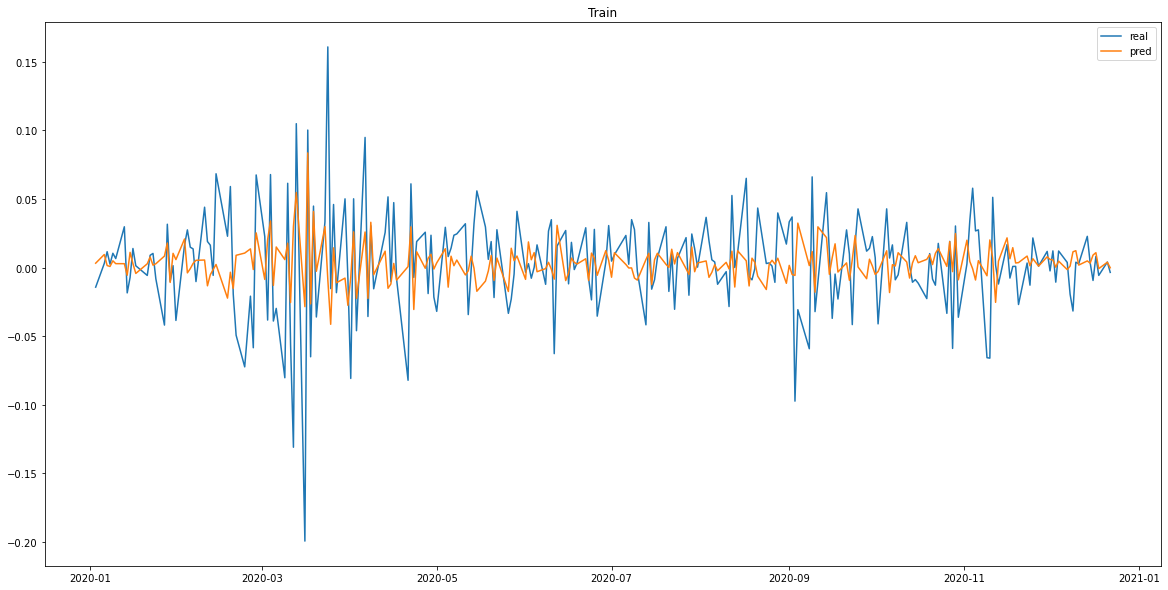

In [25]:
plt.title("Train")
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][0]].index], close_log_diff_1.iloc[fold_ids[0][0]], label='real')
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][0]].index], train_temp_pred, label='pred')
plt.legend()
plt.show()

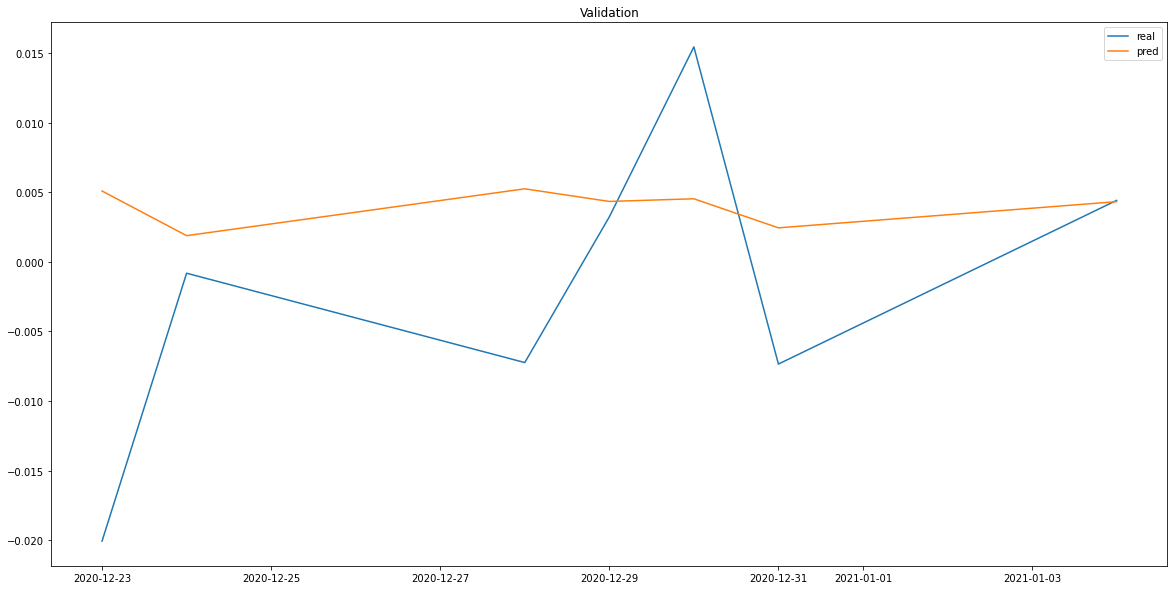

In [26]:
plt.title("Validation")
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][1]].index], close_log_diff_1.iloc[fold_ids[0][1]], label='real')
plt.plot(ts['date'].loc[close_log_diff_1.iloc[fold_ids[0][1]].index], val_temp_pred, label='pred')
plt.legend()
plt.show()

## ARIMA

In [27]:
close_log = np.log1p(ts['close'])

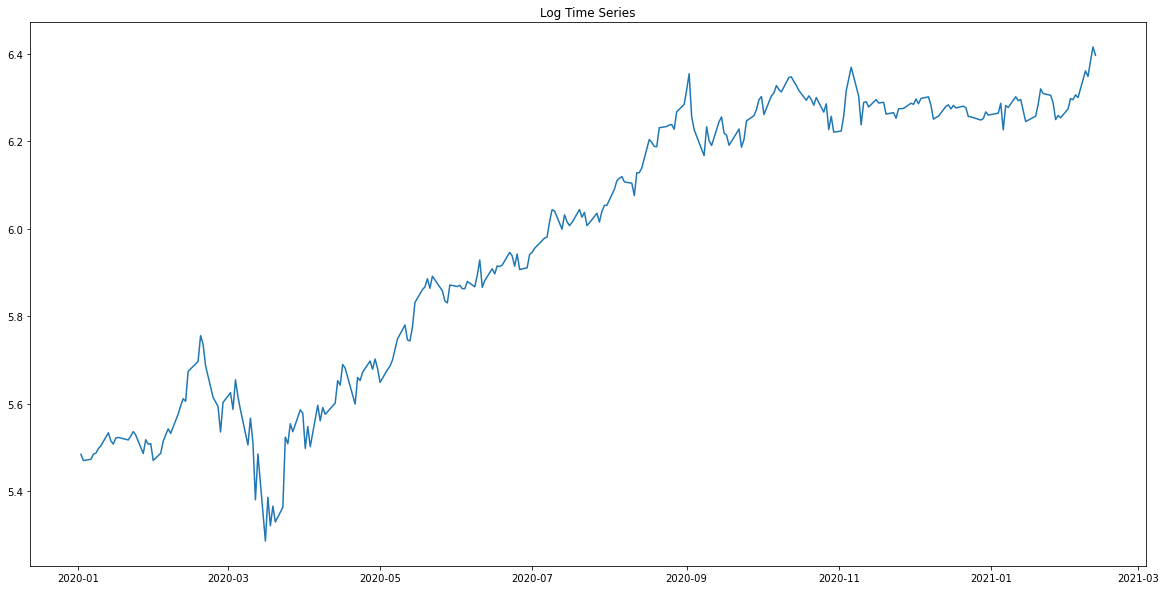

In [28]:
plt.title('Log Time Series')
plt.plot(ts['date'], close_log)
plt.show()

(array([ 7., 19., 37., 22.,  9., 31., 21., 13., 95., 26.]),
 array([5.28548539, 5.39850054, 5.51151569, 5.62453084, 5.737546  ,
        5.85056115, 5.9635763 , 6.07659145, 6.18960661, 6.30262176,
        6.41563691]),
 <BarContainer object of 10 artists>)

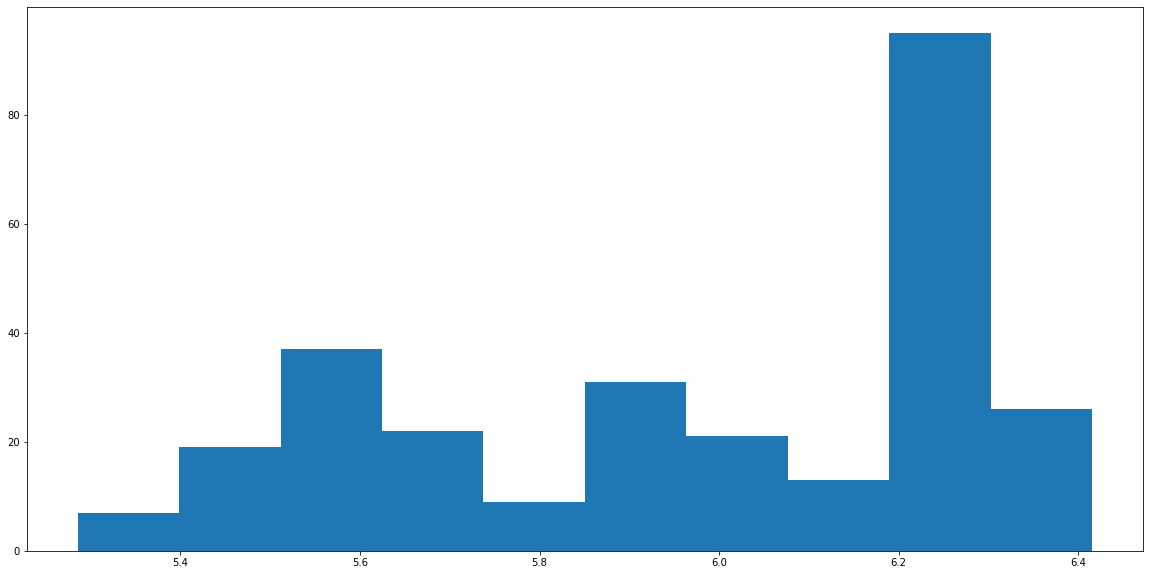

In [29]:
plt.hist(close_log)

In [ ]:
ARIMA_result = {
    "AR": [],
    "MA": [],
    "D": []
}

for autoreg in tqdm([4,5,8]):
    for moveaver in list(range(1,4)):
        for dinter in [1,2]:
            try:
                accum_metrics = []
                for fold_n, (train_ids, val_ids) in enumerate(fold_ids):
                    temp_model = StatmodelsWrapper(
                        stat_model=ARIMA,
                        stat_model_config={
                            "order": (autoreg,dinter,moveaver)
                        }
                    )

                    temp_model.fit(close_log.iloc[train_ids])

                    temp_result = compute_metrics(
                        temp_model.model.predict(),
                        close_log.iloc[train_ids],
                        'train'
                    )

                    temp_result["train_aic"] = temp_model.model.aic
                    temp_result["train_bic"] = temp_model.model.bic

                    temp_pred = temp_model.dynamic_predict(len(val_ids))

                    temp_result.update(compute_metrics(
                        temp_pred,
                        close_log.iloc[val_ids],
                        'val'
                    ))
                    accum_metrics.append(temp_result)

                    accum_metrics = avarage_by_folds(accum_metrics)

                    ARIMA_result["AR"].append(autoreg)
                    ARIMA_result["MA"].append(moveaver)
                    ARIMA_result["D"].append(dinter)
                    for k in accum_metrics.keys():
                        if k not in ARIMA_result:
                            ARIMA_result[k] = []

                        ARIMA_result[k].append(accum_metrics[k])
            except:
                print("Something has broken")

In [ ]:
ARIMA_result = pd.DataFrame(ARIMA_result)

ARIMA_result.sort_values('val_MAPE')

In [ ]:
ARIMA_result.sort_values('train_MAPE').iloc[:,:12]

In [ ]:
ARIMA_result.sort_values('val_MAPE').iloc[:,[0, 1, 2, 11, 12, 13, 14, 15, 16, 17, 18]]

In [30]:
temp_model = StatmodelsWrapper(
    stat_model=ARIMA,
    stat_model_config={
        "order": (8,1,2)
    }
)

temp_model.fit(close_log.iloc[fold_ids[0][0]])
train_temp_pred = temp_model.model.predict()
val_temp_pred = temp_model.dynamic_predict(7)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


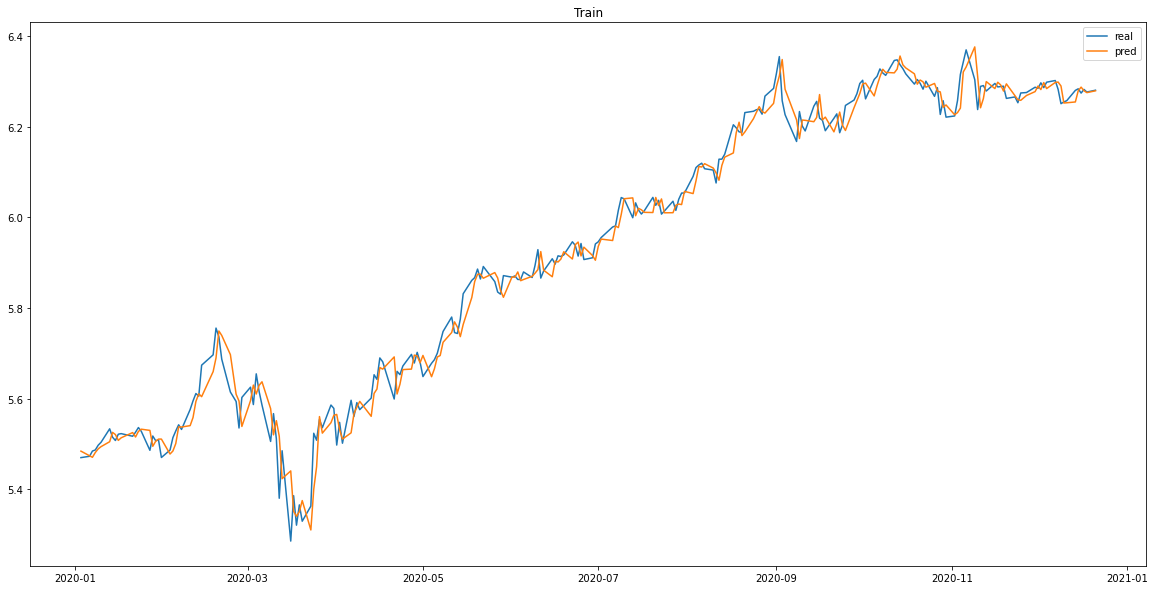

In [31]:
plt.title("Train")
plt.plot(ts['date'].loc[close_log.iloc[fold_ids[0][0]].index[1:]], close_log.iloc[fold_ids[0][0][1:]], label='real')
plt.plot(ts['date'].loc[close_log.iloc[fold_ids[0][0]].index[1:]], train_temp_pred[1:], label='pred')
plt.legend()
plt.show()

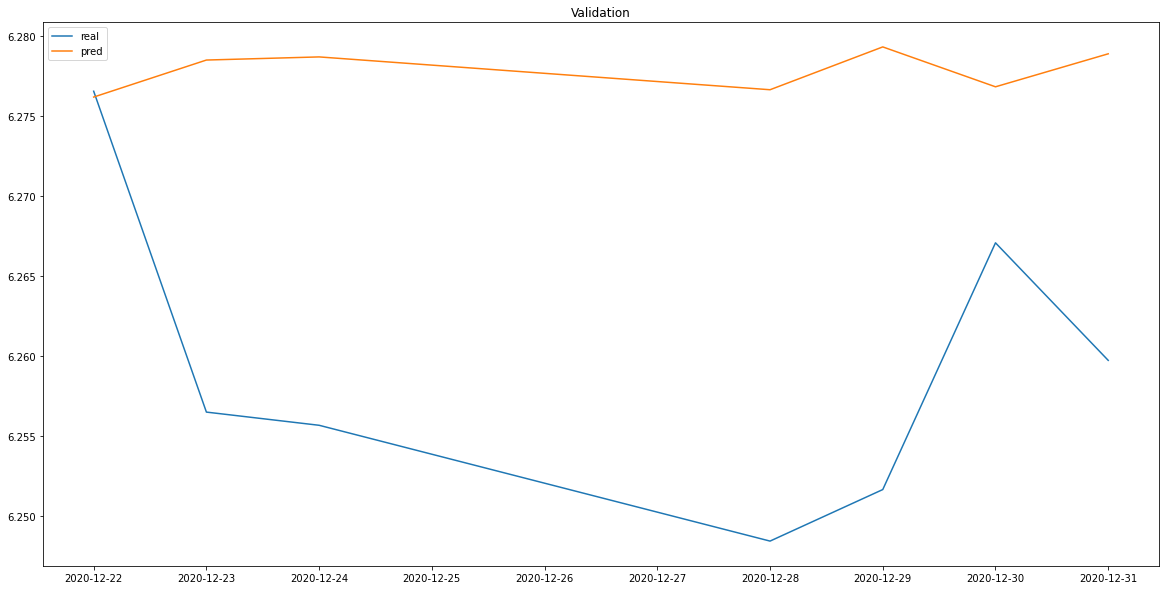

In [32]:
plt.title("Validation")
plt.plot(ts['date'].loc[close_log.iloc[fold_ids[0][1]].index], close_log.iloc[fold_ids[0][1]], label='real')
plt.plot(ts['date'].loc[close_log.iloc[fold_ids[0][1]].index], val_temp_pred, label='pred')
plt.legend()
plt.show()

## best ARMA on Log Serie

In [ ]:
accum_metrics = []
for fold_n, (train_ids, val_ids) in enumerate(fold_ids):
    temp_model = StatmodelsWrapper(
        stat_model=ARIMA,
        stat_model_config={
            "order": (5,0,3)
        }
    )

    temp_model.fit(close_log_diff_1.iloc[train_ids])
    
    train_pred = temp_model.model.predict()

    temp_result = compute_metrics(
        close_log.loc[close_log_diff_1.iloc[train_ids].index - 1] + train_pred,
        close_log.loc[close_log_diff_1.iloc[train_ids].index],
        'train'
    )

    temp_result["train_aic"] = temp_model.model.aic
    temp_result["train_bic"] = temp_model.model.bic

    temp_pred = temp_model.dynamic_predict(len(val_ids))

    temp_result.update(compute_metrics(
        close_log.loc[close_log_diff_1.iloc[val_ids].index - 1] + temp_pred,
        close_log.loc[close_log_diff_1.iloc[val_ids].index],
        'val'
    ))
    accum_metrics.append(temp_result)

accum_metrics = avarage_by_folds(accum_metrics)

In [ ]:
pd.Series(accum_metrics)

In [33]:
temp_model = StatmodelsWrapper(
    stat_model=ARIMA,
    stat_model_config={
        "order": (5,0,3)
    }
)

temp_model.fit(close_log_diff_1.iloc[fold_ids[0][0]])
train_temp_pred = temp_model.model.predict()
val_temp_pred = temp_model.dynamic_predict(7)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-p

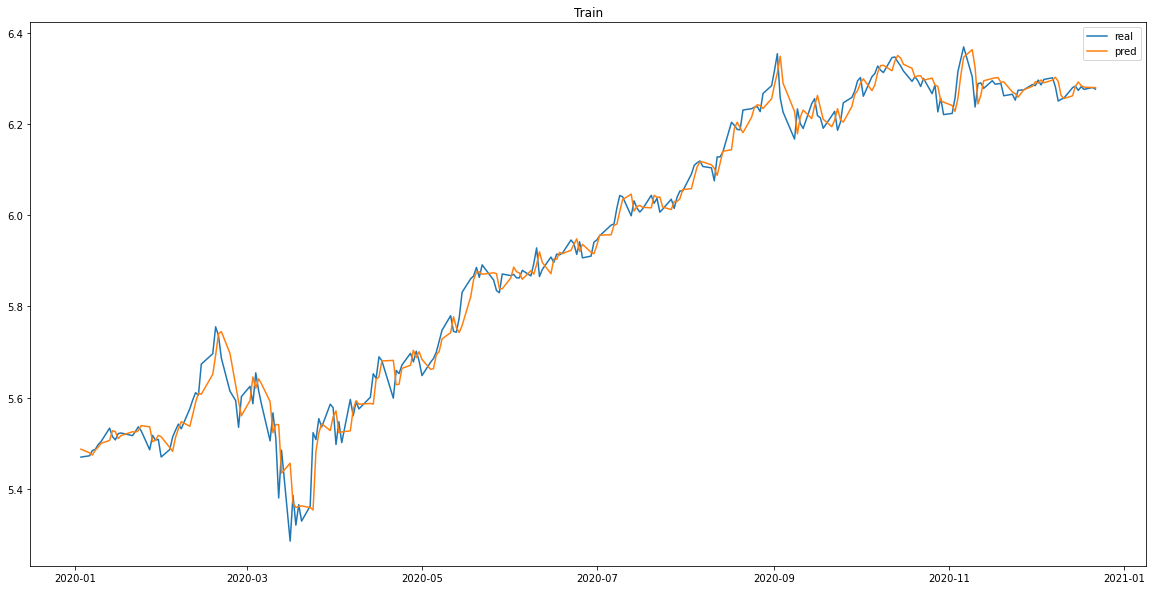

In [34]:
train_indices = close_log_diff_1.iloc[fold_ids[0][0]].index 

plt.title("Train")
plt.plot(ts['date'].loc[train_indices], close_log.iloc[train_indices], label='real')
plt.plot(ts['date'].loc[train_indices], train_temp_pred + close_log.loc[train_indices - 1], label='pred')
plt.legend()
plt.show()

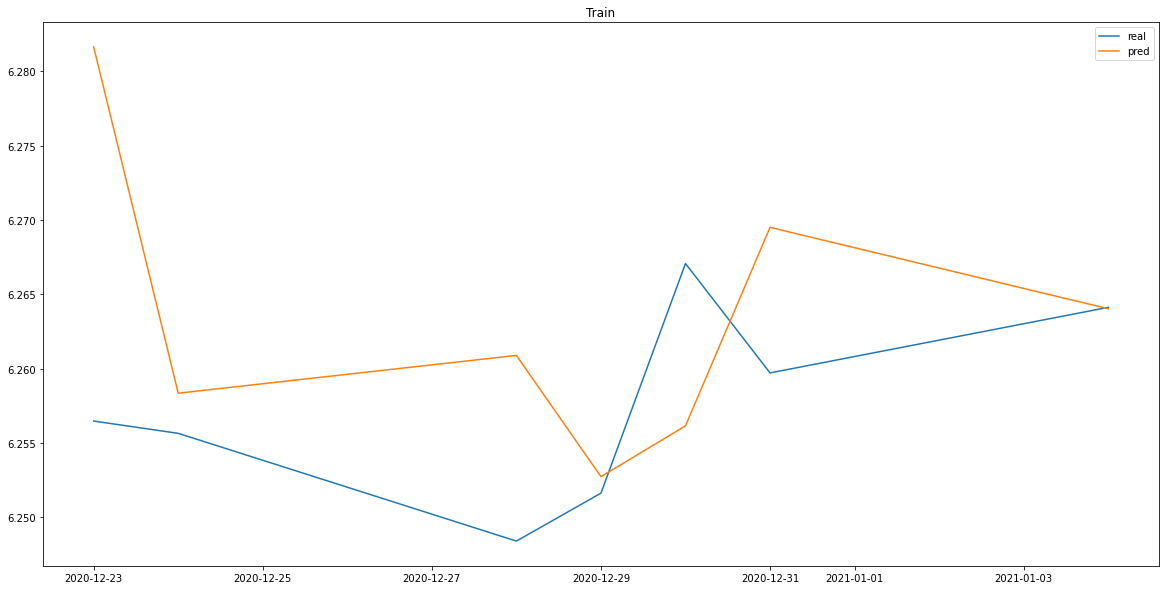

In [35]:
val_indices = close_log_diff_1.iloc[fold_ids[0][1]].index 

plt.title("Test")
plt.plot(ts['date'].loc[val_indices], close_log.iloc[val_indices], label='real')
plt.plot(ts['date'].loc[val_indices], val_temp_pred + close_log.loc[val_indices - 1], label='pred')
plt.legend()
plt.show()

# ARCH, GARCH, EGARCH, FIARCH

In [36]:
temp_model = StatmodelsWrapper(
    stat_model=ARIMA,
    stat_model_config={
        "order": (8,1,2)
    }
)

temp_model.fit(close_log.iloc[:-30])
train_temp_pred = temp_model.model.predict()
val_temp_pred = temp_model.dynamic_predict(30)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/mo

In [37]:
np.abs(close_log.iloc[-30:].values - val_temp_pred)

array([0.00549179, 0.00581282, 0.01944717, 0.04296686, 0.01442781,
       0.01112592, 0.03403249, 0.02705071, 0.02813122, 0.00462166,
       0.02205135, 0.00937467, 0.01702544, 0.05263349, 0.0425921 ,
       0.038057  , 0.02186821, 0.01734687, 0.00789388, 0.01306771,
       0.00686473, 0.0309628 , 0.02806025, 0.03932425, 0.03307369,
       0.09405863, 0.08130007, 0.11625612, 0.14896059, 0.12958457])

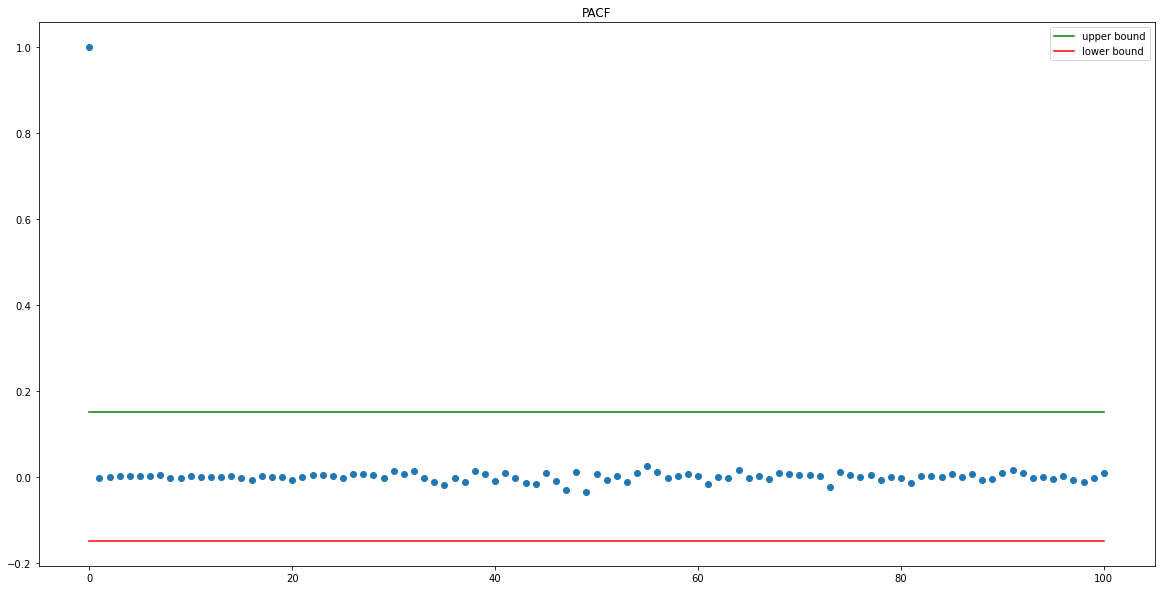

Impoetant lags:  [0]


In [38]:
build_pacf(temp_model.model.resid, 0.15, 100)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


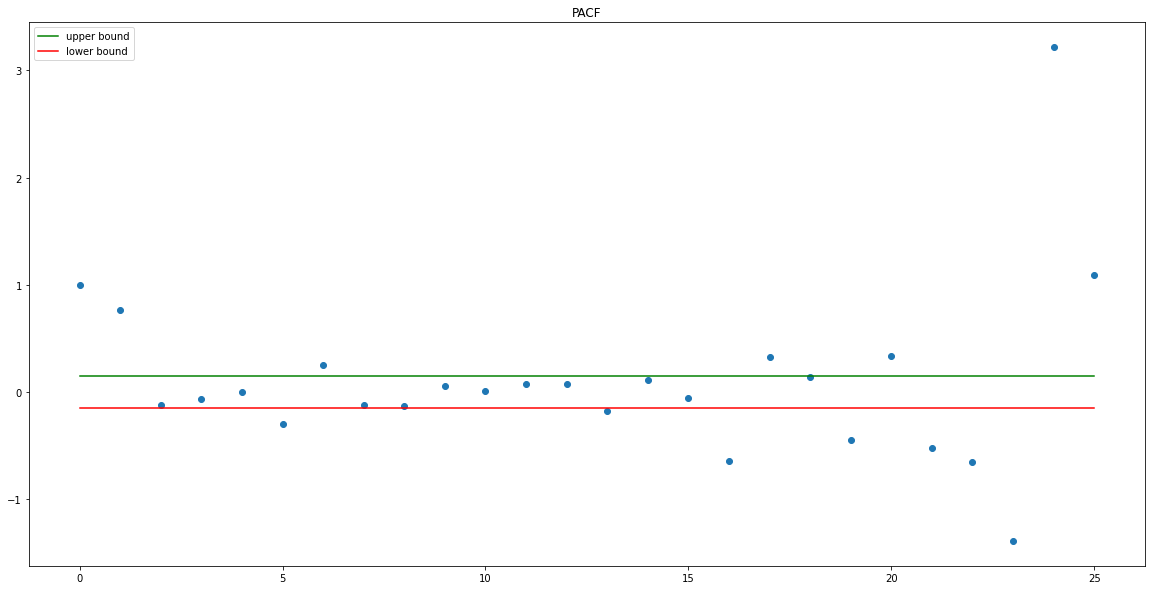

Impoetant lags:  [ 0  1  5  6 13 16 17 19 20 21 22 23 24 25]


In [39]:
build_pacf(np.abs(close_log.iloc[-30:].values - val_temp_pred), 0.15, 25)

In [40]:
temp_model = StatmodelsWrapper(
    stat_model=ARIMA,
    stat_model_config={
        "order": (8,1,2)
    }
)

temp_model.fit(close_log)
train_temp_pred = temp_model.model.predict()

In [41]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
pd.Series(dict(zip(
    labels, 
    het_breuschpagan(temp_model.model.resid[1:], close_log_diff_1.values.reshape(-1,1))
)))

LM Statistic       8.378307
LM-Test p-value         NaN
F-Statistic        8.606736
F-Test p-value     0.003628
dtype: float64

In [42]:
arima_res = temp_model.model.resid[1:]

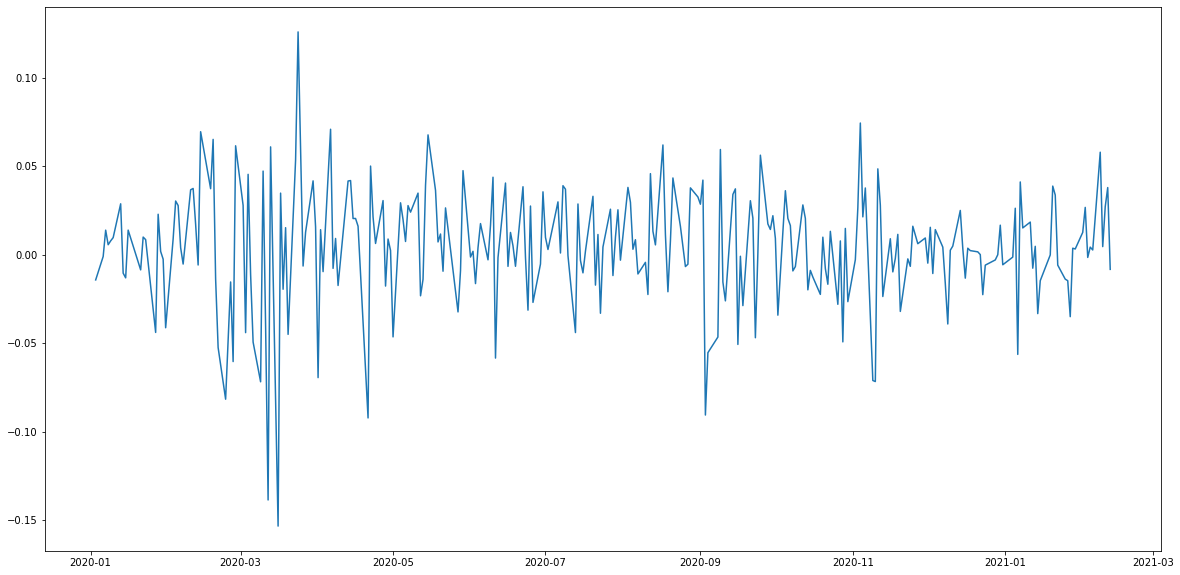

In [43]:
plt.plot(ts['date'].iloc[1:], arima_res)

(array([  2.,   0.,   6.,  16.,  38., 117.,  77.,  20.,   2.,   1.]),
 array([-0.15346813, -0.12553158, -0.09759504, -0.0696585 , -0.04172195,
        -0.01378541,  0.01415113,  0.04208768,  0.07002422,  0.09796077,
         0.12589731]),
 <BarContainer object of 10 artists>)

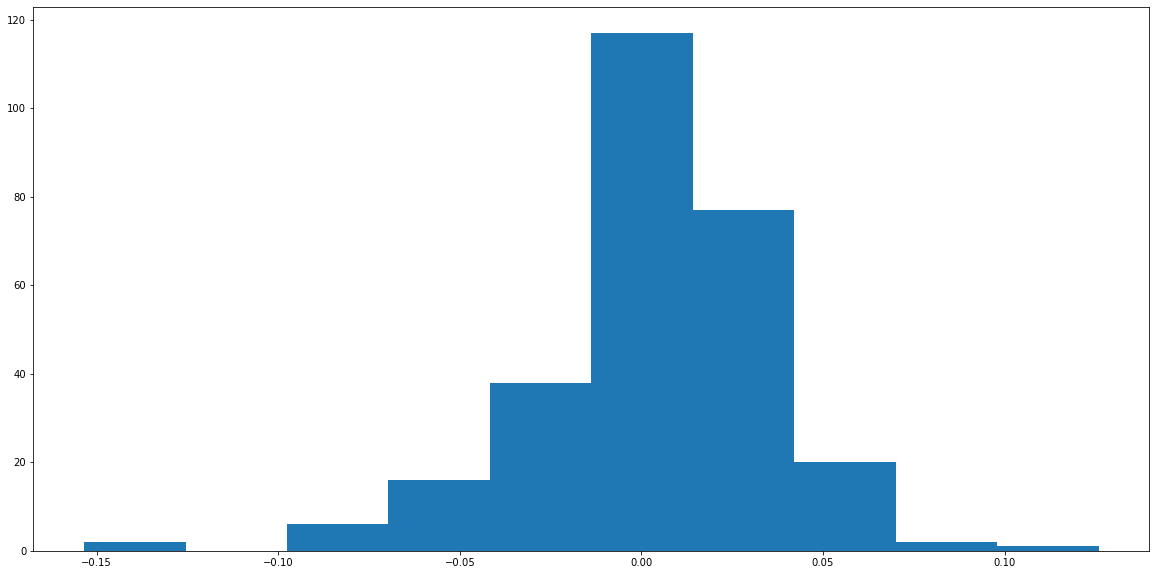

In [44]:
plt.hist(arima_res)

## Heteroscedasticity models

In [45]:
class HetModelsWrapper(object):
    def __init__(self, stat_model: object, stat_model_config):
        self.model_class = stat_model
        self.model = None
        self.model_config = stat_model_config

        self.X_len = None
        self.X = None

    def fit(self, X):
        X = np.array(X)

        self.model = self.model_class(X, **self.model_config).fit(update_freq=0)

        self.X_len = len(X)
        self.X = X

        return self

    def dynamic_predict(self, array_to_pred):
        all_pred = []
        dump_len = self.X_len
        dump_x = self.X.copy()
        for el in array_to_pred:
            pred = self.model.forecast().variance.iloc[-1,0]
            self.fit(list(self.X) + [el])
            all_pred.append(pred)

        return np.array(all_pred)

In [58]:
def make_one_exp(m_t, p_t, q_t, lag_t):
    try:
        accum_metrics = []
        for fold_n, (train_ids, val_ids) in enumerate(fold_ids):
            temp_result = dict()
            temp_model = HetModelsWrapper(
                stat_model=arch_model,
                stat_model_config={
                    "mean":"HARX",
                    "lags":lag_t,
                    "vol":m_t,
                    "p":p_t,
                    "q":q_t
                }
            )

            temp_model.fit(arima_res[train_ids])

            temp_result["train_aic"] = temp_model.model.aic
            temp_result["train_bic"] = temp_model.model.bic
            temp_result["train_R2"] = temp_model.model.rsquared

            temp_pred = temp_model.dynamic_predict(arima_res[val_ids])

            temp_result.update(compute_metrics(
                temp_pred,
                arima_res[val_ids]**2,
                'val'
            ))
            accum_metrics.append(temp_result)

        accum_metrics = avarage_by_folds(accum_metrics)
        accum_metrics["M"] = m_t
        accum_metrics["LAG"] = lag_t
        accum_metrics["P"] = p_t
        accum_metrics["Q"] = q_t
        return accum_metrics
    except:
        return {}
    
def parse_all_exp_r(list_of_dicts):
    list_of_dicts = [dic for dic in list_of_dicts if len(dic) > 0]
    all_keys = list_of_dicts[0].keys()
    return{
        k:[dic[k] for dic in list_of_dicts] for k in all_keys
    }

In [62]:
%%time

all_exp_r =  Parallel(n_jobs=12)(delayed(make_one_exp)(m, p, q, lag) for m, p, q, lag in product(
    ["ARCH", "GARCH", "FIGARCH", "EGARCH"],
    [1, 5, 15, 19],
    [1, 5, 15, 19],
    list(range(1, 5)) + [15, 16]
))

CPU times: user 1.44 s, sys: 85.2 ms, total: 1.52 s
Wall time: 3min 47s


In [64]:
HET_result = pd.DataFrame(parse_all_exp_r(all_exp_r))

HET_result

,train_aic,train_bic,train_R2,val_RMSE,val_RSS,val_R2,val_MSE,val_MAE,val_MAPE,val_durbin_watson,M,LAG,P,Q
0,-968.264292,-954.292046,-0.005064,9.441131e-04,6.789609e-06,-3.245036e+00,9.699441e-07,7.972890e-04,7.997362e+03,0.600317,ARCH,1,1,1
1,-964.721079,-947.276391,-0.011111,9.549594e-04,6.998286e-06,-3.136714e+00,9.997552e-07,7.966764e-04,7.849627e+03,0.622838,ARCH,2,1,1
2,-958.075250,-937.166469,-0.011665,9.555862e-04,7.007147e-06,-3.152718e+00,1.001021e-06,7.976614e-04,7.869682e+03,0.622799,ARCH,3,1,1
3,-953.783821,-929.419348,-0.016355,9.632664e-04,7.058429e-06,-3.225909e+00,1.008347e-06,7.999293e-04,7.846902e+03,0.645351,ARCH,4,1,1
4,-910.348394,-848.541398,-0.047318,9.649792e-04,7.658198e-06,-2.407970e+00,1.094028e-06,7.898749e-04,7.300666e+03,0.586726,ARCH,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,835567.073746,835713.609130,-0.019239,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,2,19,19
290,-983.223405,-833.377137,-0.024365,1.490030e+111,7.770665e+223,-8.352496e+228,1.110095e+223,5.631785e+110,3.920421e+113,1.132935,EGARCH,3,19,19
291,-982.252714,-829.104601,-0.022233,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,4,19,19
292,295833.732784,296022.587494,-0.067656,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,15,19,19


In [65]:
HET_result.sort_values('val_MAPE')

,train_aic,train_bic,train_R2,val_RMSE,val_RSS,val_R2,val_MSE,val_MAE,val_MAPE,val_durbin_watson,M,LAG,P,Q
154,-8.673664e+02,-7.403187e+02,8.758662e-03,0.000817,0.000005,-1.511427,7.692010e-07,6.650388e-04,2992.569832,0.603753,GARCH,15,15,5
58,-9.096264e+02,-7.997473e+02,-7.097827e-02,0.000797,0.000006,-0.375050,8.548839e-07,6.279210e-04,3050.552696,0.701860,ARCH,15,15,5
52,-9.096264e+02,-7.997473e+02,-7.097827e-02,0.000797,0.000006,-0.375050,8.548839e-07,6.279210e-04,3050.552696,0.701860,ARCH,15,15,1
64,-9.096264e+02,-7.997473e+02,-7.097827e-02,0.000797,0.000006,-0.375050,8.548839e-07,6.279210e-04,3050.552696,0.701860,ARCH,15,15,15
70,-9.096264e+02,-7.997473e+02,-7.097827e-02,0.000797,0.000006,-0.375050,8.548839e-07,6.279210e-04,3050.552696,0.701860,ARCH,15,15,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,-9.801076e+02,-8.648366e+02,-1.063824e-03,inf,inf,-inf,inf,5.136266e+306,inf,NaN,EGARCH,1,15,15
259,-9.881442e+02,-8.695203e+02,-7.993555e-03,inf,inf,-inf,inf,5.136266e+306,inf,NaN,EGARCH,2,15,15
261,2.470890e+05,2.472143e+05,-1.398387e-02,inf,inf,-inf,inf,5.136266e+306,inf,NaN,EGARCH,4,15,15
248,4.831322e+08,4.831323e+08,-4.054048e+08,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,3,15,1


In [66]:
%%time

all_exp_r =  Parallel(n_jobs=12)(delayed(make_one_exp)(m, p, q, lag) for m, p, q, lag in product(
    ["ARCH", "GARCH", "FIGARCH", "EGARCH"],
    [0,1] + list(range(14,20)),
    [0,1] + list(range(4, 10)),
    list(range(14, 20))
))

CPU times: user 4.95 s, sys: 176 ms, total: 5.13 s
Wall time: 20min 23s


In [67]:
HET_result = pd.DataFrame(parse_all_exp_r(all_exp_r))

HET_result

,train_aic,train_bic,train_R2,val_RMSE,val_RSS,val_R2,val_MSE,val_MAE,val_MAPE,val_durbin_watson,M,LAG,P,Q
0,-914.280820,-855.833472,-0.040597,0.000971,0.000008,-2.511096,0.000001,7.944919e-04,7412.951821,0.595091,ARCH,14,1,0
1,-910.348394,-848.541398,-0.047318,0.000965,0.000008,-2.407970,0.000001,7.898749e-04,7300.665796,0.586726,ARCH,15,1,0
2,-906.180666,-841.023099,-0.051623,0.000968,0.000008,-2.331118,0.000001,7.932300e-04,7229.085535,0.577742,ARCH,16,1,0
3,-904.120884,-835.621883,-0.032728,0.000972,0.000008,-2.228510,0.000001,7.944214e-04,6770.234171,0.581545,ARCH,17,1,0
4,-900.708712,-828.877477,-0.031097,0.000962,0.000008,-2.123033,0.000001,7.912136e-04,6847.995337,0.544615,ARCH,18,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,-945.760652,-791.243162,-0.053970,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,15,19,9
1028,-952.926705,-795.176806,-0.048814,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,16,19,9
1029,-940.588365,-779.615714,-0.038068,inf,inf,-inf,inf,1.027253e+307,inf,NaN,EGARCH,17,19,9
1030,-935.990929,-771.805249,-0.054430,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,18,19,9


In [71]:
HET_result.iloc[:,[0,1,2,-1,-2,-3,-4]].sort_values('train_R2', ascending=False)

,train_aic,train_bic,train_R2,Q,P,LAG,M
371,-8.741425e+02,-7.750756e+02,5.277038e-02,7,1,19,GARCH
575,-8.286235e+02,-6.680667e+02,4.876928e-02,9,17,19,GARCH
352,-8.875328e+02,-8.020194e+02,4.784957e-02,4,1,18,GARCH
382,-8.739824e+02,-7.713663e+02,4.713207e-02,9,1,18,GARCH
605,-8.360205e+02,-6.822960e+02,4.704125e-02,6,18,19,GARCH
...,...,...,...,...,...,...,...
851,1.035234e+07,1.035247e+07,-1.978359e+10,1,16,19,EGARCH
819,2.417295e+20,2.417295e+20,-2.496200e+12,6,15,17,EGARCH
906,1.746327e+10,1.746327e+10,-3.030198e+13,5,17,14,EGARCH
767,1.443668e+10,1.443668e+10,-8.213949e+13,5,14,19,EGARCH


In [73]:
HET_result.iloc[:,3:].sort_values('val_RMSE')

,val_RMSE,val_RSS,val_R2,val_MSE,val_MAE,val_MAPE,val_durbin_watson,M,LAG,P,Q
554,0.000749,0.000005,-0.417722,6.930337e-07,6.191060e-04,4508.145070,0.555214,GARCH,16,17,6
487,0.000753,0.000005,-0.669682,6.701124e-07,5.975635e-04,3039.810936,0.688554,GARCH,15,16,1
439,0.000756,0.000005,-0.515645,7.106160e-07,6.213587e-04,3052.830236,0.575234,GARCH,15,15,1
397,0.000769,0.000005,-1.119089,6.839647e-07,6.193123e-04,6582.553817,0.685821,GARCH,15,14,4
586,0.000770,0.000005,-0.801058,7.108505e-07,6.434322e-04,4133.172829,0.512518,GARCH,18,18,1
...,...,...,...,...,...,...,...,...,...,...,...
853,inf,inf,-inf,inf,2.054506e+307,inf,NaN,EGARCH,15,16,4
854,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,16,16,4
855,inf,inf,-inf,inf,1.027253e+307,inf,NaN,EGARCH,17,16,4
837,inf,inf,-inf,inf,inf,inf,NaN,EGARCH,17,15,9


In [74]:
temp_model = HetModelsWrapper(
    stat_model=arch_model,
    stat_model_config={
        "mean":"HARX",
        "lags":16,
        "vol":"GARCH",
        "p":17,
        "q":6
    }
)

temp_model.fit(arima_res[fold_ids[0][0]])
temp_pred = temp_model.dynamic_predict(arima_res[fold_ids[0][1]])

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -479.20369164520196
            Iterations: 56
            Function evaluations: 2386
            Gradient evaluations: 55


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -481.4765411692214
            Iterations: 56
            Function evaluations: 2387
            Gradient evaluations: 55


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -484.31139664881385
            Iterations: 55
            Function evaluations: 2345
            Gradient evaluations: 54


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -486.9414230876822
            Iterations: 59
            Function evaluations: 2492
            Gradient evaluations: 57


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -489.84272264563594
            Iterations: 58
            Function evaluations: 2445
            Gradient evaluations: 56


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -492.8151621059236
            Iterations: 55
            Function evaluations: 2350
            Gradient evaluations: 54


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -496.16985047493955
            Iterations: 49
            Function evaluations: 2093
            Gradient evaluations: 48


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Optimization terminated successfully    (Exit mode 0)
            Current function value: -499.5659670109617
            Iterations: 57
            Function evaluations: 2462
            Gradient evaluations: 56


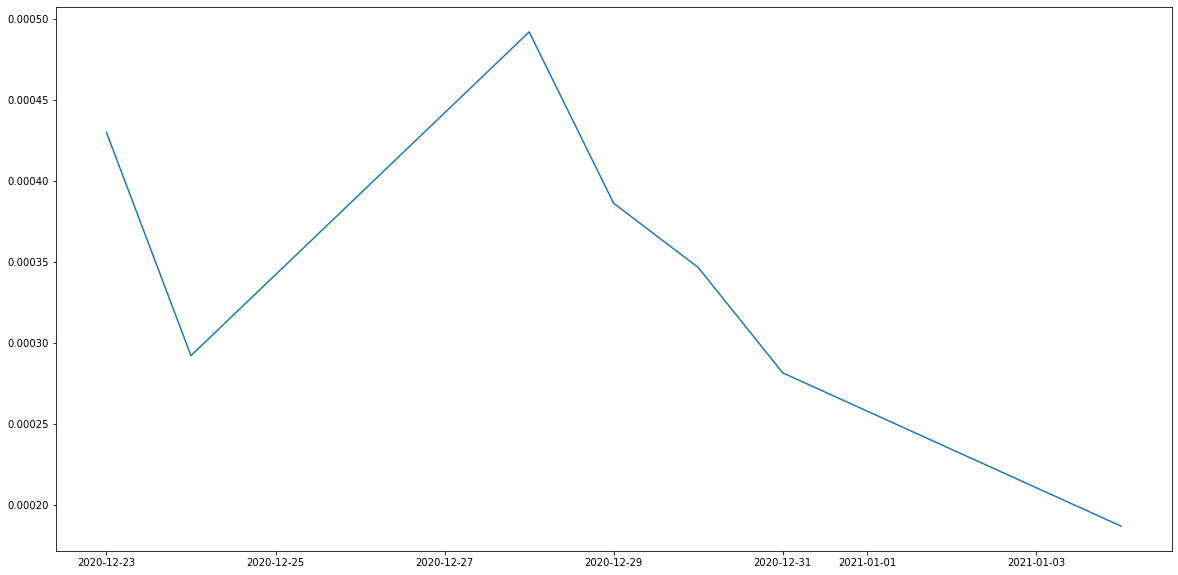

In [76]:
plt.plot(ts.date.iloc[fold_ids[0][1] + 1], temp_pred)

# Final Prediction

In [77]:
train_part = close_log.iloc[:-7]
test_part = close_log.iloc[-7:]

In [78]:
temp_model = StatmodelsWrapper(
    stat_model=ARIMA,
    stat_model_config={
        "order": (8,1,2)
    }
)

temp_model.fit(train_part)
test_pred_pred = temp_model.dynamic_predict(7)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [83]:
pd.Series(compute_metrics(
    test_part,
    test_pred_pred,
    "test"
))

test_RMSE               0.077579
test_RSS                0.042129
test_R2              -457.455724
test_MSE                0.006018
test_MAE                0.064666
test_MAPE               0.010277
test_durbin_watson      0.140158
dtype: float64

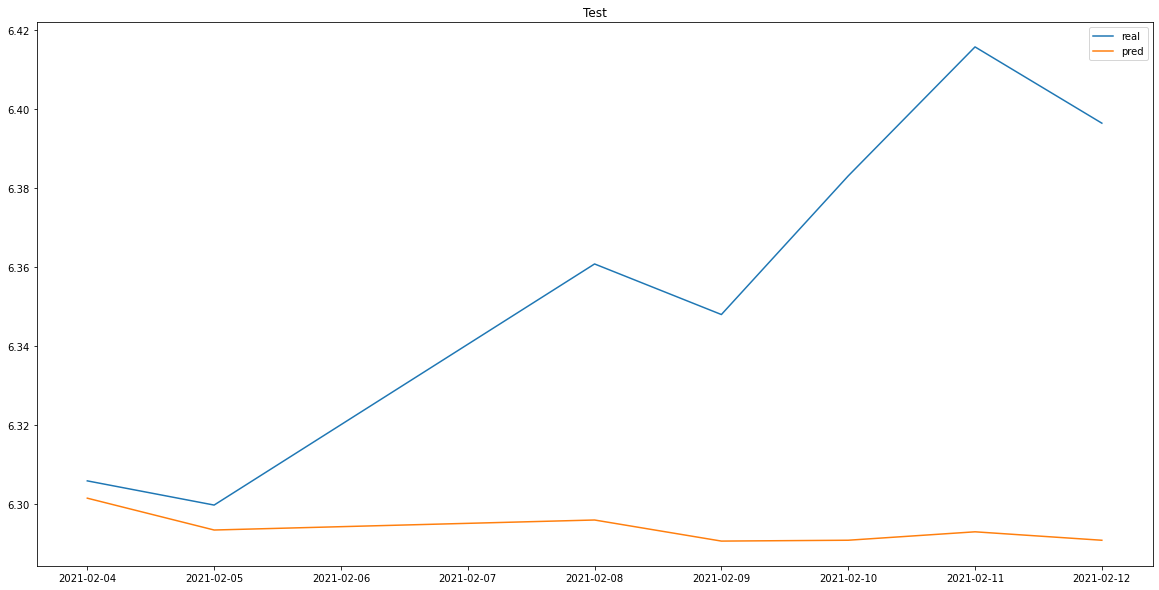

In [81]:
plt.title("Test")
plt.plot(ts.date.iloc[-7:], test_part, label='real')
plt.plot(ts.date.iloc[-7:], test_pred_pred, label='pred')
plt.legend()
plt.show()

In [85]:
train_part = arima_res[:-7]
test_part = arima_res[-7:]

In [86]:
temp_model = HetModelsWrapper(
    stat_model=arch_model,
    stat_model_config={
        "mean":"HARX",
        "lags":16,
        "vol":"GARCH",
        "p":17,
        "q":6
    }
)

temp_model.fit(train_part)
test_pred_pred = temp_model.dynamic_predict(test_part)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-p

Optimization terminated successfully    (Exit mode 0)
            Current function value: -525.673245811854
            Iterations: 17
            Function evaluations: 593
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -546.2783863496342
            Iterations: 39
            Function evaluations: 1649
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -525.4885868379498
            Iterations: 7
            Function evaluations: 135
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -530.7628956154874
            Iterations: 14
            Function evaluations: 454
            Gradient evaluations: 10


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-p

Optimization terminated successfully    (Exit mode 0)
            Current function value: -534.0198835050489
            Iterations: 17
            Function evaluations: 595
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -533.3558652491524
            Iterations: 12
            Function evaluations: 363
            Gradient evaluations: 8


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-p

Optimization terminated successfully    (Exit mode 0)
            Current function value: -553.9062672208374
            Iterations: 39
            Function evaluations: 1660
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -535.110215517995
            Iterations: 7
            Function evaluations: 135
            Gradient evaluations: 3


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001101. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [87]:
pd.Series(compute_metrics(
    test_part**2,
    test_pred_pred,
    "test"
))

test_RMSE              0.001132
test_RSS               0.000009
test_R2              -19.621646
test_MSE               0.000001
test_MAE               0.000817
test_MAPE              1.217991
test_durbin_watson     1.154753
dtype: float64

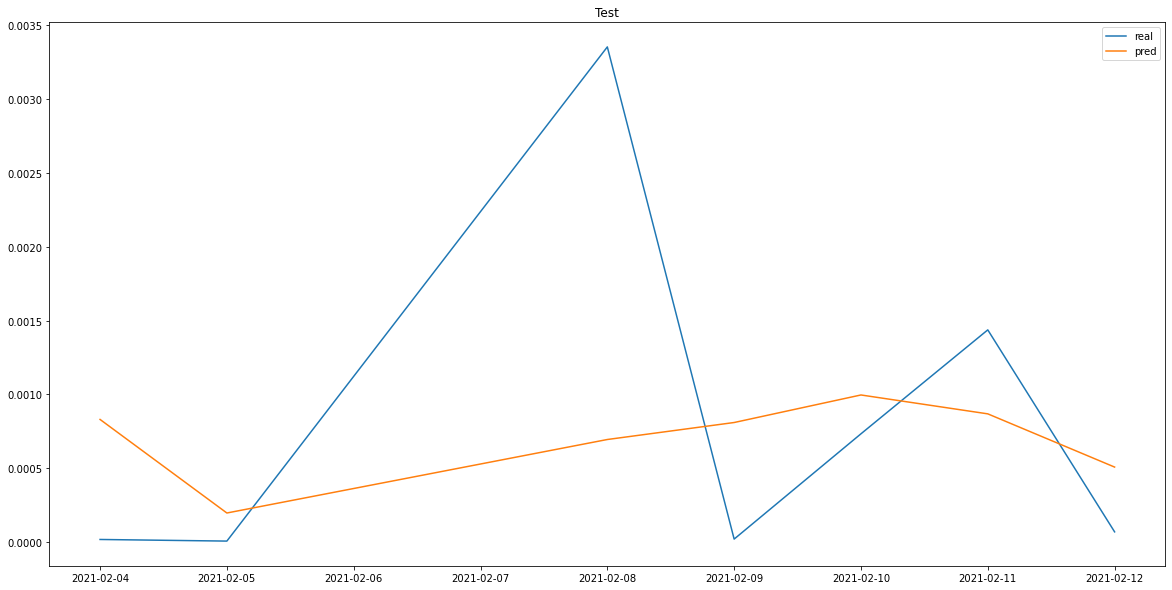

In [88]:
plt.title("Test")
plt.plot(ts.date.iloc[-7:], test_part**2, label='real')
plt.plot(ts.date.iloc[-7:], test_pred_pred, label='pred')
plt.legend()
plt.show()